# WATER BAG TIME SERIE CLASSIFICATION - Prediction Range Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Group related split, evaluation and probability methods (Authoral)
from Modulos.imbalanced_selection import (
    groupConsecutiveFlags, MinorityGroupSplitUndersample,
    group_metrics, scoring, cross_val_predict_proba
)
from Modulos.probability import (
    predict_proba, scale_proba, clf_score, precision_recall_plot,
    groups_windows, window_prob, multi_window_prob
)

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms
from sklearn.model_selection import cross_validate, TimeSeriesSplit
# from sklearn.feature_selection import SelectFromModel, SelectKBest
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

C:\Users\luisr\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Utility Funcitons

In [3]:
from sklearn.preprocessing import LabelEncoder as le

def custom_preprocessing(X, drop_empty_cols=True, label_encode=None, interpolate='linear', fillna='mean'):

    print('Initial shape:', X.shape)

    if drop_empty_cols: # Drop X empty columns and rows
        X.dropna(axis=1, how='all', inplace=True)
        print('Empty columns removed: ', X.shape)

    if label_encode is not None:
        print('Label columns encoded:', list(label_encode))
        for col in label_encode:
            X[col] = le().fit_transform(X[col])

    if interpolate is not None: # Interpolate X missing values
        print('Interpolation:', interpolate)
        X = X.interpolate(interpolate)

    if fillna is not None: # Fill missing values with the minimum column value
        print('Fill missing values:', fillna)
        for col in X:
            if fillna=='min':
                fill_value = X[col].min()
            elif fillna=='mean':
                fill_value = X[col].mean()
            else:
                fill_value = 0
            X[col].fillna(fill_value, inplace=True)

    return X

# Target selection and train/test split
def select_target(target_id, periods_ahead, shift=0):
    print(f'Selected Target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    y_cnt = Y.value_counts().to_frame('Target')

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(1 - periods_ahead) > 0).astype('float')
        print('Periods ahead:', periods_ahead)
    if shift is not None:
        Y = Y.shift(shift, fill_value=0.)
        print('Period shift:', shift)

    y_cnt = pd.concat([y_cnt, Y.value_counts().to_frame('Transformed Target')], axis=1)

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)
    
    return Y, groups, y_cnt

def target_params_evaluation(target_id, params, pipe, sel_thresh=0.5):

    scrs = []
    for i, param in enumerate(params):
        co(wait=True); print(f'{i+1}/{len(params)} shift values evaluated.')

        ### Target variable
        
        Y, groups, y_cnt = select_target(target_id, **param)

        # Target validation split
        yt = Y.loc[xt.index]
        ye = Y.loc[xe.index]
        groups_train = groups.loc[xt.index]
        groups_eval = groups.loc[xe.index]

        ### Fit and predict with model pipeline

        # Fit pipeline
        pipe.fit(xt, yt)

        # Predict Probability
        yprob = predict_proba(pipe, xe)
        # yprob = scale_proba(yprob, 0.5, limit=None)

        ### Prediction evaluation

        grp_curve = group_metrics.group_precision_recall_curve(ye, yprob, groups_eval, num=50)
        scr_grp = grp_curve[sel_thresh:].iloc[0]
        scr = clf_score(ye, yprob, sel_thresh).rename(columns={'f1-score': 'f1'})

        scr = pd.concat([scr.loc['1.0'].add_suffix('-1'), scr_grp], axis=0)
        for key in param.keys():
            scr[key] = param[key]
        scrs.append(scr)

    scrs = pd.concat(scrs, axis=1).T
    return scrs

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data.drop('index', axis=1)
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


---
# 1. Preprocessing & Data Transformation

### Feature set

In [5]:
train_start, train_end = '2018-06', '2020-07'
eval_start, eval_end = '2020-08', '2022-04'

transform_args = dict(
    drop_empty_cols=True,
    label_encode=data.columns[:11],
    interpolate='linear', fillna='mean'
)

X = custom_preprocessing(data[train_start: eval_end].copy(), **transform_args)

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

Initial shape: (137280, 241)
Empty columns removed:  (137280, 228)
Label columns encoded: ['year', 'month', 'day', 'hour', 'minute', 'date', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: linear
Fill missing values: mean


---
# 3. Simple split pipeline evaluation

### Base model

In [11]:
seed = 0

# sgd = classifiers['SGDClassifier']

# # Initialize model
# model = sgd(
#     loss='log', penalty='l1', alpha=0.0003, l1_ratio=0.15, # l1_ratio only used if penalty is elasticnet
#     early_stopping=False, tol=0.0001, n_iter_no_change=5, max_iter=25,
#     validation_fraction=0.1, random_state=seed, verbose=1, n_jobs=-1,
# )

logistc = classifiers['LogisticRegression']

model = logistc(
    penalty='l1',
    dual=False,
    tol=0.001,
    C=1.0,
    random_state=0,
    solver='liblinear',
    max_iter=100,
    verbose=True,
    n_jobs=-1,
)

train_prct = 0.025
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)

# Pipeline
pipe = Pipeline([('scale', mms()), ('under', rus), ('model', model)])

---
# Target shift evaluation

In [72]:
scr_cols = np.array(['precision-1', 'recall-1', 'f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

### Period shift evaluation

17/17 shift values evaluated.
Selected Target: Rua do Catete - id: 1 

Periods ahead: 4
Period shift: 16


c:\Users\luisr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]predict_proba method used.


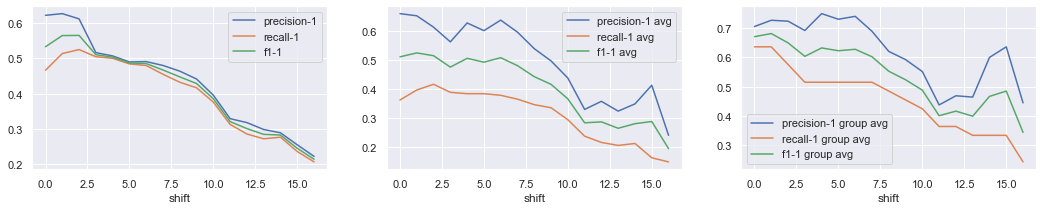

In [97]:
target_id = '1'
sel_thresh = 0.5
shifts = range(0, 17, 1)

params = [{'shift': shift, 'periods_ahead': 4} for shift in shifts]
scrs_shift = target_params_evaluation(target_id, params, pipe, sel_thresh=0.5).set_index('shift')

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
for i, col_type in enumerate(['', ' avg', ' group avg']):
    scrs_shift[scr_cols + col_type].plot(ax=ax[i])
plt.show()

### Period range evaluation

17/17 shift values evaluated.
Selected Target: Rua do Catete - id: 1 

Periods ahead: 16
Period shift: 0


c:\Users\luisr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]predict_proba method used.


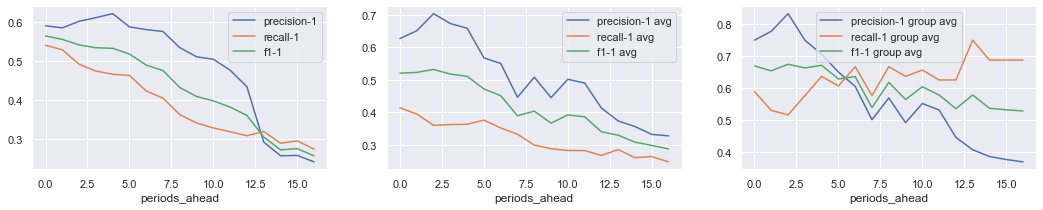

In [98]:
target_id = '1'
sel_thresh = 0.5
periods = [None] + list(range(1, 17, 1))

params = [{'shift': 0, 'periods_ahead': period} for period in periods]
scrs_periods = target_params_evaluation(target_id, params, pipe, sel_thresh=0.5).set_index('periods_ahead')
scrs_periods.index = scrs_periods.index.fillna(0.)

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
for i, col_type in enumerate(['', ' avg', ' group avg']):
    scrs_periods[scr_cols + col_type].plot(ax=ax[i])
plt.show()